In [1]:
import config

import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
DATA_DIR = "data_/"
# fixed for each efficientnet model
IMG_SIZE = 224 
NUM_CLASSES = 1
EPOCH = 10

In [3]:

val_data = image_dataset_from_directory(
                DATA_DIR,
                labels="inferred",
                color_mode="rgb",
                batch_size=32,
                image_size=(IMG_SIZE, IMG_SIZE),
                validation_split=0.2,
                subset="training",
                seed=1
            )

train_data = image_dataset_from_directory(
                DATA_DIR,
                labels="inferred",
                label_mode="int",
                class_names=None,
                color_mode="rgb",
                batch_size=32,
                image_size=(IMG_SIZE, IMG_SIZE),
                validation_split=0.2,
                subset="validation",
                seed=1
            )

Found 204 files belonging to 2 classes.
Using 164 files for training.
Found 204 files belonging to 2 classes.
Using 40 files for validation.


2021-10-18 08:35:46.802464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 08:35:46.807467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-18 08:35:46.808198: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-18 08:35:46.809463: I tensorflow/core/platform/cpu_feature_guard.cc:142] This Tensor

In [5]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
print(val_data)
type(val_data)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [7]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [8]:
def build_model(NUM_CLASSES):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    img_augmentation = Sequential(
        [
            layers.RandomRotation(factor=0.15),
            layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            layers.RandomFlip(),
            layers.RandomContrast(factor=0.1),
        ],
        name="img_augmentation",
    )

    x = img_augmentation(inputs)
    # model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    model = EfficientNetB0(include_top=False, input_tensor=x, weights='model/efficientnetb0_notop.h5')

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, 
        loss="binary_crossentropy", 
        metrics=["accuracy"]
    )
    return model

In [9]:
model = build_model(NUM_CLASSES)

In [10]:
# with strategy.scope():
#     model = build_model(num_classes=NUM_CLASSES)
hist = model.fit(train_data, 
                 epochs=EPOCH, 
                 validation_data=val_data, 
                 verbose=2)


Epoch 1/10


2021-10-18 08:36:18.309315: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2/2 - 9s - loss: 0.9934 - accuracy: 0.4750 - val_loss: 0.7887 - val_accuracy: 0.4024
Epoch 2/10
2/2 - 3s - loss: 0.4009 - accuracy: 0.4750 - val_loss: 0.9271 - val_accuracy: 0.4024
Epoch 3/10
2/2 - 3s - loss: 0.3326 - accuracy: 0.4750 - val_loss: 1.1186 - val_accuracy: 0.4024
Epoch 4/10
2/2 - 3s - loss: 0.4502 - accuracy: 0.4750 - val_loss: 1.2709 - val_accuracy: 0.4024
Epoch 5/10
2/2 - 3s - loss: 0.5286 - accuracy: 0.4750 - val_loss: 1.3450 - val_accuracy: 0.4024
Epoch 6/10
2/2 - 3s - loss: 0.3906 - accuracy: 0.4750 - val_loss: 1.3399 - val_accuracy: 0.4024
Epoch 7/10
2/2 - 3s - loss: 0.2165 - accuracy: 0.4750 - val_loss: 1.2777 - val_accuracy: 0.4024
Epoch 8/10
2/2 - 3s - loss: 0.1940 - accuracy: 0.4750 - val_loss: 1.1755 - val_accuracy: 0.4024
Epoch 9/10
2/2 - 3s - loss: 0.1290 - accuracy: 0.4750 - val_loss: 1.0972 - val_accuracy: 0.4024
Epoch 10/10
2/2 - 3s - loss: 0.1103 - accuracy: 0.4750 - val_loss: 1.0702 - val_accuracy: 0.4024


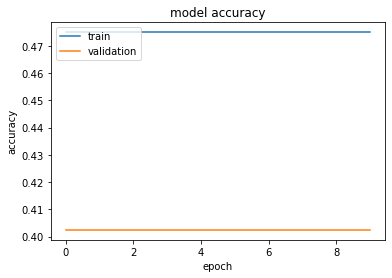

In [11]:
plot_hist(hist)